## Week 4 Video Notebook -- Testing and Validation for Fitting a Polynomial Model


The goal of this notebook and video are to continue to explore the question raised at the end of the last video: How do we choose the **right** model, neither underfitting nor overfitting?

The key insight presented this week is that we can simulate having new data by separating our dataset into training, validation, and testing sets. As long as these sets are kept separate, the performance of a model on the final testing set is a good indicator of how well the model generalizes.  Validation sets are an intermediate testing set that can alternate with bouts of training. 

My favorite analogy:

    training set = content of a college course that you (the model) are trying to learn
    validation set = quizzes during the semester to evaluate how well you are learning
    test set = final exam

This notebook and video show how to determine the degree of the best-fitting polynomial model using 3 different paradigms. 

- Train/Test split (for a warm-up, its not actually legit to select a model based on the test set!)
- Train/Validation/Test split
- Cross-Validation plus final test

In [1]:
# Useful imports

import numpy as np
from numpy import arange,linspace,mean, var, std
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt 
import matplotlib.mlab as mlab
from numpy.random import random, normal 
from numpy.linalg import inv
import math
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# globals

random_state = 42

In [2]:
# Create a synthetic polynomial model with parameters size, error_std, degree

coefs_1 = np.array([  1.6, 2.4])

coefs_2 = np.array([  1.6, -12.3,  24.])

coefs_3 = np.array([0.125,-1.2,3,0.5])

coefs_4 = np.array([  0.23427614,  -3.35522544,  15.65103668, -25.52842645,  13.9475209 ])

coefs_5 = np.array([   0.54166667,   -9.58333333,   63.125     , -190.41666667,
        257.33333333, -116.        ])

coefs_6 = np.array([ 2.39638892e-02, -5.09286377e-01,  4.17779554e+00, -1.66057417e+01,
  3.29983964e+01, -2.97380095e+01,  1.07972123e+01])

coefs_7 = np.array([ 2.39638892e-02, -5.09286377e-01,  4.17779554e+00, -1.66057417e+01,
  3.29983964e+01, -2.97380095e+01,  1.07972123e+01, 4])

coefs_8 = np.array([-2.54744334e-02,  6.69020107e-01, -7.19978730e+00,  4.09252080e+01,
       -1.32042473e+02,  2.41711291e+02, -2.36876099e+02,  1.08327091e+02,-1.47302836e+01])

polynomials = [ None, coefs_1, coefs_2, coefs_3,coefs_4,coefs_5,coefs_6,coefs_7,coefs_8]

def f(x,coefs):
    cs = coefs[::-1]
    s = 0.0
    for d in range(len(cs)):
        s += cs[d] * x**d
    return s

def create_polynomial_dataset(size = 50, error_std = 0.5, deg = 8, 
                              lb = 0.25, ub = 6.5, show_model=True, 
                              display_dataset=True,random_state=random_state
                             ):
    coefs = polynomials[deg]
    # data to plot the perfect model
    if len(coefs) > 0:
        X_all = np.linspace(lb,ub,1000)
        Y_perfect_model = f(X_all,coefs)
                
    # create the model
    
    np.random.seed(random_state)

    X = np.random.uniform(low=lb, high=ub, size=size)
    Y = f(X,coefs) + np.random.normal(0, error_std,size=size)
    
    if display_dataset:
        plt.figure(figsize=(10, 6))

        if len(X) <=20:
            marker = 'o'
        else:
            marker = '.'
        plt.scatter(X, Y, label='Noisy Data', marker=marker,color='blue')
        if show_model:
            plt.plot(X_all, Y_perfect_model, label='Perfect Model $f$', color='grey', alpha=0.5)
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title(f'Noisy Dataset')
        plt.legend()
        plt.grid(True)
        plt.show()

    return (X,Y)

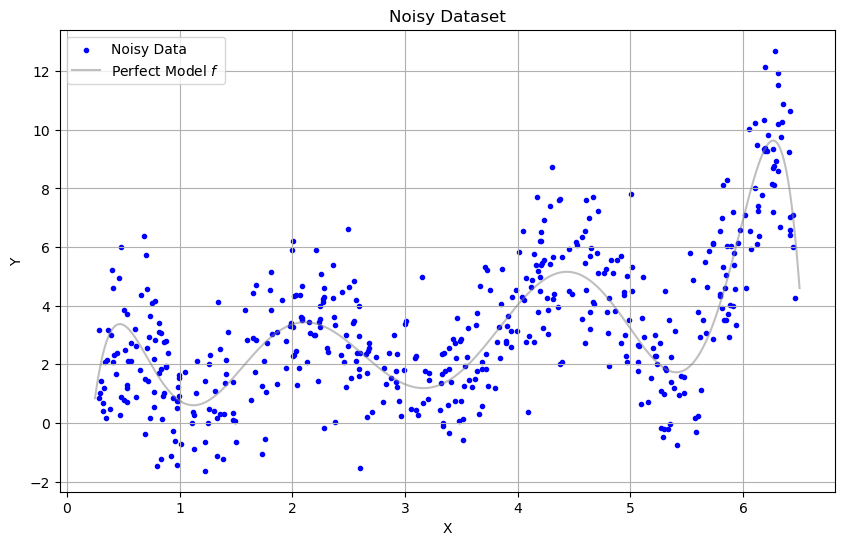

In [3]:
(X,Y) = create_polynomial_dataset(size=500,error_std=1.5,deg=8,show_model=True)

### Your Turn!

Experiment with different degrees, sizes, and error standard deviations, both with and without the model being shown. 

### 1. Static Train / Test Split

First let's consider how to choose the degree of polynomial model that best fits the dataset
by evaluating the MSE on the test set.   This is actually **NOT** appropriate, since that would be like taking the final exam in a class multiple times to see what you should study. However, its useful to see how it works and compare it with the two better frameworks presented afterwards. 

In [4]:
# static train/test split


def train_test(X,Y,test_percent=0.2,degree_ub=12,show_plot=True):

    # Split the data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_percent)

    train_mses = []
    test_mses = []

    for degree in range(1,degree_ub+1):

        model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

        model.fit(X_train.reshape(-1,1), Y_train)

        # Train the model
        Y_train_pred = model.predict(X_train.reshape(-1,1))
        Y_test_pred = model.predict(X_test.reshape(-1,1))

        # Evaluate the model
        train_MSE = mean_squared_error(Y_train,Y_train_pred)
        test_MSE = mean_squared_error(Y_test,Y_test_pred)

        train_mses.append(train_MSE)
        test_mses.append(test_MSE)



    min_test_mse = np.min(test_mses)
    min_test_degree = np.where(test_mses == min_test_mse)[0][0]+1
    
    if show_plot:
        print(f'Minimum Test MSE {min_test_mse:.4f} at degree {min_test_degree}')

        plt.title("Training and Testing MSE vs Degree")
        plt.plot(range(1,degree_ub+1),train_mses,marker='.',label="Training MSE")
        plt.plot(range(1,degree_ub+1),test_mses,marker='.',color='red',label="Testing MSE")
        plt.xlabel("Degree of Polynomial Model")
        plt.ylabel("MSE")
    #     plt.ylim([0,10])
        plt.legend()
        plt.grid()
        plt.show()

    return min_test_mse,min_test_degree,train_mses,test_mses


Minimum Test MSE 2.2620 at degree 9


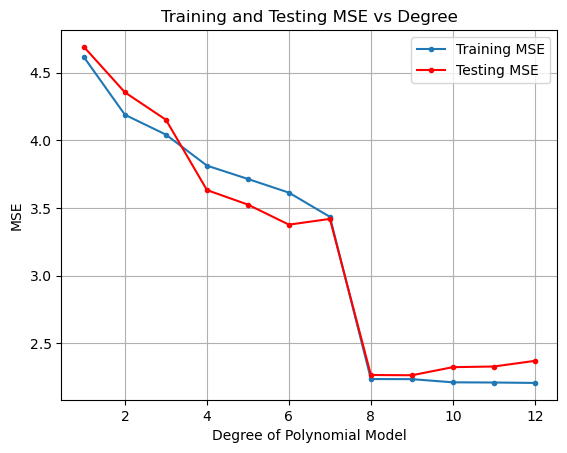

In [6]:
_ = train_test(X,Y,test_percent=0.2)

### Your Turn!

Again, create various datasets, and run `train_test` on each. 

- What is the effect on the plots of each of the parameters test_percent, size, error_std, degree?
- How well does the framework help determine the correct model under various dataset sizes and error stds?

### 2. Static Train / Validation / Test Split

In [6]:
# static train/validation/test split

def train_validation_test(X,Y,test_percent=0.2,validation_percent=0.2,degree_ub=12,show_plot=True):

    # Split the data into training and test sets
    X_train, X_rest, Y_train, Y_rest = train_test_split(X, Y, test_size=test_percent+validation_percent,random_state=random_state)
    X_valid, X_test, Y_valid, Y_test = train_test_split(X_rest, Y_rest, test_size=test_percent/(test_percent+validation_percent),random_state=random_state)

    # print(len(X_train),len(X_valid),len(X_test))

    train_mses = []
    validation_mses = []

    for degree in range(1,degree_ub+1):

        model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

        model.fit(X_train.reshape(-1,1), Y_train)

        # Train the model
        Y_train_pred = model.predict(X_train.reshape(-1,1))
        Y_validation_pred = model.predict(X_valid.reshape(-1,1))

        # Evaluate the model
        train_mse = mean_squared_error(Y_train,Y_train_pred)
        validation_mse = mean_squared_error(Y_valid,Y_validation_pred)

        train_mses.append(train_mse)
        validation_mses.append(validation_mse)

    min_validation_mse = np.min(validation_mses)
    min_validation_degree = np.where(validation_mses == min_validation_mse)[0][0]+1
#     print(f'Minimum Validation mse {min_validation_mse:.4f} at degree {min_validation_degree}')

    model = make_pipeline(PolynomialFeatures(min_validation_degree), LinearRegression())

    model.fit(X_train.reshape(-1,1), Y_train)

    # Train the model
    Y_test_pred = model.predict(X_test.reshape(-1,1))

    # Evaluate the model
    test_mse = mean_squared_error(Y_test,Y_test_pred)

#     print(f'Test mse at degree {min_validation_degree}:  {test_mse:.4f}')

    if show_plot:
        print(f'Minimum Validation mse {min_validation_mse:.4f} at degree {min_validation_degree}')
        print(f'Test mse at degree {min_validation_degree}:  {test_mse:.4f}')
        plt.title("Training and Validation mse vs Degree")
        plt.plot(range(1,degree_ub+1),train_mses,marker='.',label="Training mse")
        plt.plot(range(1,degree_ub+1),validation_mses,marker='.',label="Validation mse")
        plt.scatter([min_validation_degree],[test_mse],marker='x',color='red',label="Test mse")
        plt.xlabel("Degree of Polynomial Model")
        plt.ylabel("mse")
        # plt.ylim([0,100])
        plt.legend()
        plt.grid()
        plt.show()

    return min_validation_mse,min_validation_degree,train_mses,validation_mses,test_mse



Minimum Validation mse 2.3222 at degree 11
Test mse at degree 11:  3.0849


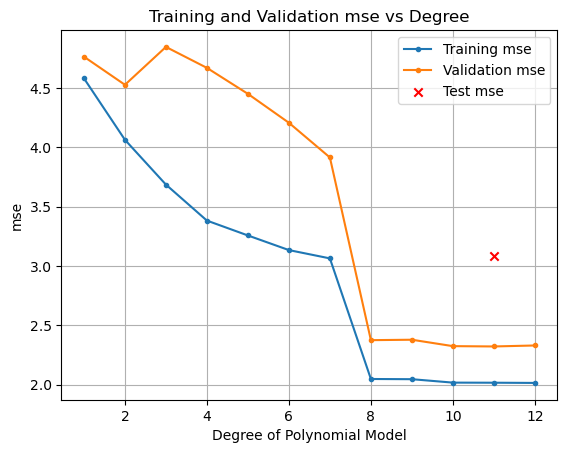

In [7]:
_ = train_validation_test(X,Y,test_percent=0.2,validation_percent=0.2)

### Your Turn!

Again, create various datasets, and run `train_test` on each. Try different test and validation percentages. 

- What is the effect on the plots of each of the parameters test_percent and valid_percent?
- How well does the framework help determine the correct model under various sizes and error stds?
- How well do the validation and test results compare?

### Cross-Validation and Testing

In [9]:
# 5-fold Cross-validation plus held-out test set

from sklearn.model_selection import cross_val_score, train_test_split,LeaveOneOut

def cross_validation_test(X,Y,test_percent=0.2,loo=False,k_folds=5,degree_ub=12,show_plot=True):

    # Split the data into training and test sets
    test_percent = 0.20
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_percent,random_state=random_state)

    # Store mean training and cross-validation MSEs
    train_mses = []
    cv_mses = []

    if loo:
        cv = LeaveOneOut()
    else:
        cv = k_folds

    for degree in range(1, degree_ub + 1):
        model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

        # Compute cross-validation MSE (negative because sklearn minimizes internally)
        cv_scores = -cross_val_score(model, X_train.reshape(-1, 1), Y_train, scoring='neg_mean_squared_error', cv=cv)
        mean_cv_mse = np.mean(cv_scores)

        # Fit the model to calculate training MSE
        model.fit(X_train.reshape(-1, 1), Y_train)
        Y_train_pred = model.predict(X_train.reshape(-1, 1))
        train_mse = mean_squared_error(Y_train, Y_train_pred)

        train_mses.append(train_mse)
        cv_mses.append(mean_cv_mse)

    # Find the degree with the minimum cross-validation MSE
    min_cv_mse = np.min(cv_mses)
    min_cv_degree = np.argmin(cv_mses) + 1
#     print(f'Minimum Validation MSE {min_cv_mse:.4f} at degree {min_cv_degree}')

    # Train the final model on the full training set with the best degree
    final_model = make_pipeline(PolynomialFeatures(min_cv_degree), LinearRegression())
    final_model.fit(X_train.reshape(-1, 1), Y_train)

    # Evaluate the model on the test set
    Y_test_pred = final_model.predict(X_test.reshape(-1, 1))
    test_mse = mean_squared_error(Y_test, Y_test_pred)
#     print(f'Test MSE at degree {min_cv_degree}: {test_mse:.4f}')

    if show_plot:
        print(f'Minimum Validation MSE {min_cv_mse:.4f} at degree {min_cv_degree}')
        print(f'Test MSE at degree {min_cv_degree}: {test_mse:.4f}')
        # Plot the MSE values
        if loo:
            plt.title("Training and LOO CV MSE vs Degree")
        else:
            plt.title("Training and Cross-Validation MSE vs Degree")
        plt.plot(range(1, degree_ub + 1), train_mses, marker='.', label="Training MSE")
        plt.plot(range(1, degree_ub + 1), cv_mses, marker='.', label="Cross-Validation MSE")
        plt.scatter([min_cv_degree], [test_mse], marker='x', color='red', label="Test MSE")
        plt.xlabel("Degree of Polynomial Model")
        plt.ylabel("MSE")
        plt.ylim([0,10])
        plt.legend()
        plt.grid()
        plt.show()

    return min_cv_mse,min_cv_degree,train_mses,cv_mses,test_mse



Minimum Validation MSE 2.3362 at degree 10
Test MSE at degree 10: 2.4507


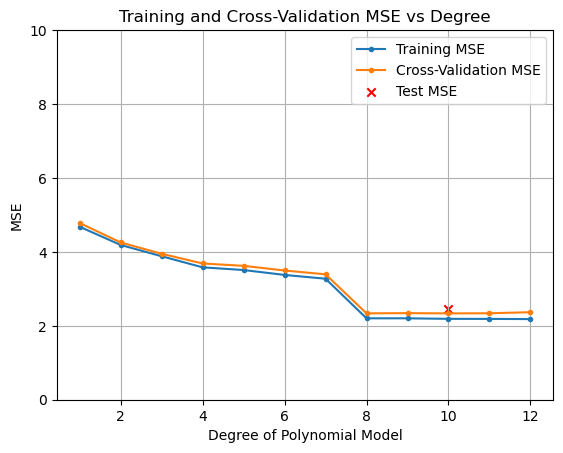

In [10]:
_ = cross_validation_test(X,Y,test_percent=0.2,loo=False,k_folds=5)

### Leave-One-Out Cross-Validation (LOOCV)



Minimum Validation MSE 2.3107 at degree 8
Test MSE at degree 8: 2.4394


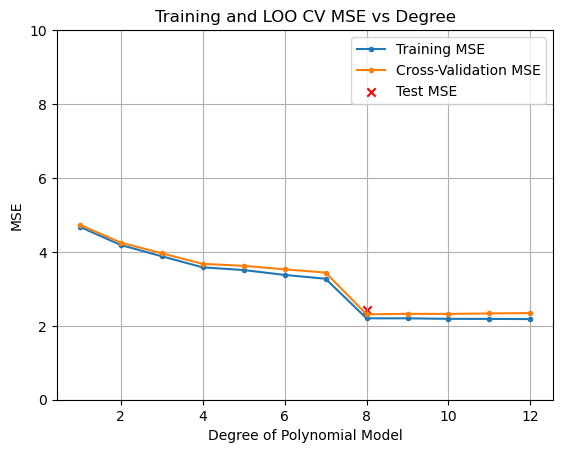

In [11]:
_ =cross_validation_test(X,Y,test_percent=0.2,loo=True,k_folds=None,degree_ub=12,show_plot=True)

### Your Turn!

Again, create various datasets, and run `cross_validation_test` on each. Try different values for `k_folds` and also try LOOCV. 

- What is the effect on the plots of the various `k_folds`?
- How do they compare with LOOCV (which is in fact the case where `k_folds` = size of dataset)?

In [13]:
# 4/0

### Summing Up: Let's Compare

In [14]:
# Collect best model preds from all four options using defaults for error_std, and degree
# It is useful when doing these kinds of comparisons to have as much data as possible, so we'll
# use size = 500

num_trials = 100

degree_ub = 15
                            
tt = []
tvt = []
cvt = []
loocvt = []


for _ in tqdm(range(num_trials)):

    (X,Y) = create_polynomial_dataset(size=500,error_std=0.5,show_model=False, display_dataset=False,random_state=None)

    _,min_test_degree,_,_         = train_test(X,Y,test_percent=0.2,degree_ub=degree_ub,show_plot=False)
    _,min_validation_degree,_,_,_ = train_validation_test(X,Y,test_percent=0.2,validation_percent=0.2,degree_ub=degree_ub,show_plot=False)
    _,min_cv_degree,_,_,_         = cross_validation_test(X,Y,test_percent=0.2,loo=False,k_folds=5,degree_ub=degree_ub,show_plot=False)
    _,min_loocv_degree,_,_,_      = cross_validation_test(X,Y,test_percent=0.2,loo=True,k_folds=None,degree_ub=degree_ub,show_plot=False)
    tt.append(min_test_degree)
    tvt.append(min_validation_degree)
    cvt.append(min_cv_degree)
    loocvt.append(min_loocv_degree)

100%|██████████| 100/100 [05:04<00:00,  3.04s/it]


In [17]:
from joblib import Parallel, delayed
import numpy as np
from tqdm import tqdm

num_trials = 100
degree_ub = 15
size = 500
error_std = 0.5
test_percent = 0.2
validation_percent = 0.2

# Define the function for a single trial
def run_trial():
    (X, Y) = create_polynomial_dataset(size=size, error_std=error_std, show_model=False, display_dataset=False)

    _, min_test_degree, _, _ = train_test(X, Y, test_percent=test_percent, degree_ub=degree_ub, show_plot=False)
    _, min_validation_degree, _, _, _ = train_validation_test(X, Y, test_percent=test_percent, validation_percent=validation_percent, degree_ub=degree_ub, show_plot=False)
    _, min_cv_degree, _, _, _ = cross_validation_test(X, Y, test_percent=test_percent, loo=False, k_folds=5, degree_ub=degree_ub, show_plot=False)
    _, min_loocv_degree, _, _, _ = cross_validation_test(X, Y, test_percent=test_percent, loo=True, k_folds=None, degree_ub=degree_ub, show_plot=False)

    return min_test_degree, min_validation_degree, min_cv_degree, min_loocv_degree

# Run in parallel using all available CPU cores
results = Parallel(n_jobs=-1, backend="loky")(delayed(run_trial)() for _ in tqdm(range(num_trials)))

# Convert results to NumPy arrays for fast operations
tt, tvt, cvt, loocvt = np.array(results).T

100%|██████████| 100/100 [00:24<00:00,  4.13it/s]


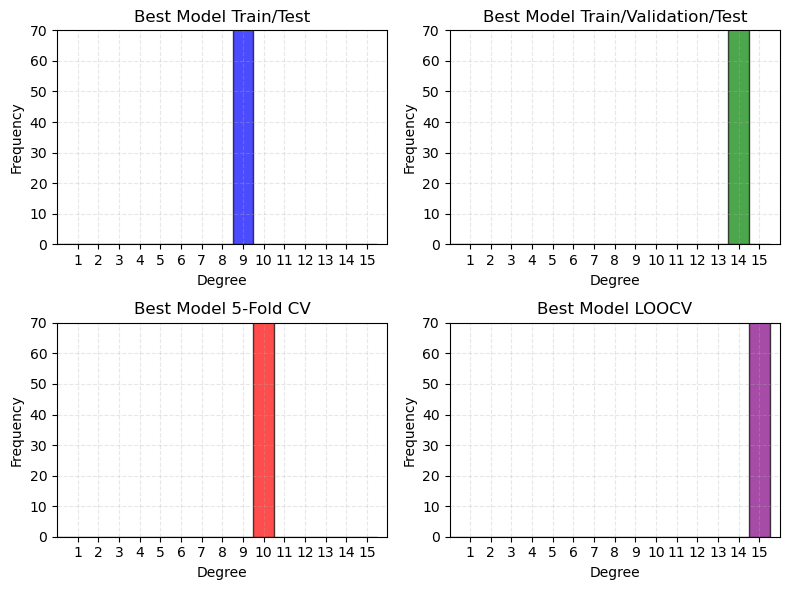

In [18]:
# Creating a 2x2 matrix of histograms

fig, axes = plt.subplots(2, 2, figsize=(8, 6))

data = [tt, tvt, cvt, loocvt]
titles = ['Best Model Train/Test', 'Best Model Train/Validation/Test', 'Best Model 5-Fold CV', 'Best Model LOOCV']
colors = ['blue', 'green', 'red', 'purple']

# Plotting each histogram
for i, ax in enumerate(axes.flat):
    counts, bins, patches = ax.hist(
        data[i], 
        bins=np.arange(-0.5, 16.5, 1),  # Ensure bins cover 1 to 15
        color=colors[i], 
        edgecolor='black',
        alpha=0.7,
        weights=np.ones_like(data[i]) * 100 / len(data[i])  # Normalize to percentages
    )
    ax.set_title(titles[i])
    ax.set_xticks(np.arange(1, 16))  # Set ticks from 1 to 15
    ax.set_xlim(0, 16)  # Set x-axis limits to 0 to 16
    ax.set_ylim(0, 50)  # Set y-axis limits to a consistent range
    ax.set_xticklabels([int(x) for x in np.arange(1, 16)])  # Set x-axis labels as integers
    ax.set_xlabel('Degree')
    
    # Set y-axis to percentages
    ax.set_ylabel('Frequency')
    ax.set_yticks(np.arange(0, 80, 10))  # Set percentage tick marks
    
    ax.grid(True, linestyle='--', alpha=0.3)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

### Optional 

Again, play around with various settings for the parameters, and see how each framework did in terms of the variance of the results as shown by the histogram. 

- When does LOOCV have a smaller variance than 5-Fold CV?
- Does CV always do better than T/V/T?